In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import torch.nn as nn

from torch import utils
from torch import optim
from torch import device
from torch import inference_mode

import tqdm

from timeit import default_timer as timer
from tqdm.auto import tqdm

from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy
from torchvision.transforms.v2 import (
    ConvertImageDtype,
    Normalize,
    Resize,
    CenterCrop,
    ToTensor,
    ToImage,
    Compose
)

import medmnist
from medmnist import INFO, Evaluator

In [2]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")
for i in range(num_gpus):
    print(f"{i+1}. GPU {i}: {torch.cuda.get_device_name(i)}")

device = 0  # "Select the index of the GPU you wish to use"
torch.cuda.set_device(device)
print(f"GPU selection: {torch.cuda.get_device_name(device)}")

device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device1}")

Number of GPUs available: 1
1. GPU 0: NVIDIA GeForce MX110
GPU selection: NVIDIA GeForce MX110
Using device: cuda:0


In [3]:
transformacion = Compose([
    ToTensor(), 
    Normalize(mean=[0.5], std=[0.5])
    ])

/home/pablo/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
data_flag = "pathmnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info["python_class"])

# Load the training and testing datasets
train_data = DataClass(split="train", transform=transformacion, download=True)
val_data = DataClass(split="val", transform=transformacion, download=True)
test_data = DataClass(split="test", transform=transformacion, download=True)

100%|██████████| 205615438/205615438 [00:20<00:00, 10059790.46it/s]


Using downloaded and verified file: /home/pablo/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/pablo/.medmnist/pathmnist.npz


In [5]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [6]:
# Number of image channels
n_channels = info["n_channels"]
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info["label"])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info["label"]
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].


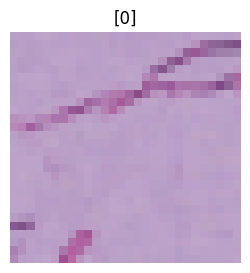

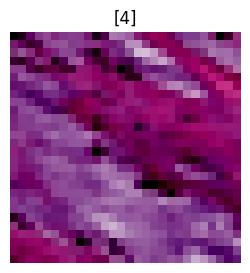

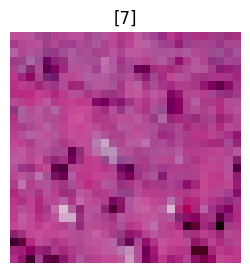

In [7]:
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False)

In [8]:
# change data into dataloader form
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# check dataloader
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fd88dd53cd0>, <torch.utils.data.dataloader.DataLoader object at 0x7fd88dd53490>)
Length of train dataloader: 704 batches of 128
Length of test dataloader: 57 batches of 128
Length of val dataloader: 79 batches of 128


In [10]:
# define training loop functions
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):

    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # need to change target shape for this medmnist data
        y = y.squeeze().long()

        # Send data to selected device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [11]:
def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):

    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval()  # eval mode for testing
    with torch.inference_mode():  # Inference context manager
        for X, y in data_loader:
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        return test_loss, test_acc

In [12]:
def eval_func(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):

    eval_loss, eval_acc = 0, 0
    model.to(device)

    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):
            # need to change target shape for this medmnist data
            y = y.squeeze().long()

            # Send data to selected device
            X, y = X.to(device), y.to(device)

            # Forward pass
            eval_pred = model(X)

            # Find loss and accuracy
            eval_loss += loss_fn(eval_pred, y)
            eval_acc += accuracy_fn(y_true=y, y_pred=eval_pred.argmax(dim=1))

            # Add prediction and target labels to list
            eval_labels = torch.argmax(torch.softmax(eval_pred, dim=1), dim=1)
            y_preds.append(eval_labels)
            y_targets.append(y)

        # Scale loss and acc
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)

        # Put predictions on CPU for evaluation
        y_preds = torch.cat(y_preds).cpu()
        y_targets = torch.cat(y_targets).cpu()

        return {
            "model_name": model.__class__.__name__,
            "loss": eval_loss.item(),
            "accuracy": eval_acc,
            "predictions": y_preds,
            "targets": y_targets,
        }

In [13]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, out_channels=hidden_units, kernel_size=3
            ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, out_channels=hidden_units, kernel_size=3
            ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units, out_channels=hidden_units * 4, kernel_size=3
            ),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units * 4,
                out_channels=hidden_units * 4,
                kernel_size=3,
            ),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units * 4,
                out_channels=hidden_units * 4,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_units * 4 * 4 * 4, hidden_units * 8),
            nn.ReLU(),
            nn.Linear(hidden_units * 8, hidden_units * 8),
            nn.ReLU(),
            nn.Linear(hidden_units * 8, n_classes),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Define Model
model = cnn(input_shape=n_channels, hidden_units=16, output_shape=n_classes).to(device)


# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# View Model
model

cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [17]:
torch.manual_seed(42)

# Measure Time

train_time_start_model = timer()

iteration_loss_list = []
iteration_accuracy_list = []

# set parameters
epochs = 10
best_loss = 10

# call train and test function
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device1,
    )

    test_loss, test_acc = test_step(
        data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device1,
    )

    for iteration, (x, y) in enumerate(train_dataloader):
        iteration_loss_list.append(train_loss.item())
        iteration_accuracy_list.append(train_acc)

    print(
        f"Epoch: {epoch} | Training loss: {train_loss:.3f} | Training acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}"
    )

    # save best model instance

    if test_loss < best_loss:
        best_loss = test_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(obj=model.state_dict(), f="./model.pth")


train_time_end_model = timer()
total_train_time_model = print_train_time(
    start=train_time_start_model, end=train_time_end_model, device=device1
)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Load model
loaded_model = cnn(input_shape=n_channels, hidden_units=16, output_shape=n_classes).to(
    device
)

loaded_model.load_state_dict(torch.load(f="./model.pth"))

# get results
model_results = eval_func(
    data_loader=val_dataloader,
    model=loaded_model,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)

model_results

In [ ]:
# Get Model predictions and true targets
y_targets = model_results["targets"]
y_preds = model_results["predictions"]

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7)
)

In [ ]:
# Get Model predictions and true targets
y_targets = model_results["targets"]
y_preds = model_results["predictions"]

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7)
)